# TD-IDF Vectorization

In [1]:
!pip install wordcloud 
!pip install nltk 
!pip install spacy 
!pip install PyPDF2 
!pip install scikit-learn 
!pip install gensim 
!pip install joblib 
!pip install pandas 
!pip install matplotlib 
!pip install seaborn 
!pip install numpy
!pip install fasttext
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
!pip install transformers
!pip install torch torchvision torchaudio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.stem import WordNetLemmatizer
import PyPDF2
import io
import sys
from spacy.matcher import Matcher
import spacy
from PyPDF2 import PdfReader
import json
from spacy.matcher import Matcher
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
import pickle
import joblib
from sklearn.svm import SVC
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification

     ---------------------------------------- 12.8/12.8 MB 6.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ---------------------------------------- 42.8/42.8 MB 3.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


ERROR: Invalid requirement: 'torchvision\xa0torchaudio'


In [2]:
df = pd.read_csv('UpdatedResumeDataSet.csv')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


## Preprocessing Step

In [3]:


# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

def preprocess_text(text):
    
    loaded_mwe_list = []
    with open('data/mwe_list.txt', 'r') as file:
        for line in file:
            loaded_mwe_list.append(tuple(line.strip().split()))
    # Define multi-word expressions
    mwe_list = loaded_mwe_list
    # Lowercasing
    text = text.lower()

    # Remove special characters
    text = re.sub(r'\W', ' ', text)

    # MWETokenizer
    mwe_tokenizer = MWETokenizer(mwe_list, separator='_')
    
    # First tokenize to single words
    single_word_tokens = word_tokenize(text)

    # Then use MWETokenizer
    tokens = mwe_tokenizer.tokenize(single_word_tokens)

    # Stopwords removal
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(w) for w in tokens]

    return lemmatized_text

def extract_skills_backup(skills_per_category, processed_text_from_spacy):
    # Load spaCy model
    nlp = spacy.load('en_core_web_sm')
    
    # Convert the processed_text_from_spacy string to a spaCy Doc object
    doc = nlp(processed_text_from_spacy)

    # Extract skills using spaCy Matcher and skills dictionary
    matcher = Matcher(nlp.vocab)

    # Create patterns from skills dictionary
    for category, category_skills in skills_per_category.items():
        for skill in category_skills:
            pattern = [{"LOWER": token.lower()} for token in skill.split()]
            matcher.add(category + "_" + skill.replace(" ", "_"), [pattern])

    matches = matcher(doc)
    matched_skills = []
    seen_skills = set()  # To keep track of unique skills

    for match_id, start, end in matches:
        skill_text = doc[start:end].text.split("_")[1] if "_" in doc[start:end].text else doc[start:end].text
        if skill_text not in seen_skills:
            matched_skills.append(skill_text)
            seen_skills.add(skill_text)
    return matched_skills

resume_text = df['Resume'][0]

processed_text = preprocess_text(resume_text)
preprocessed_teXt_str = ' '.join(processed_text)

In [4]:


def extract_skills(text):
    # Example skill set (you would expand this list)
    
    # Load the list from the text file
    loaded_skills = []
    with open('data/predefined_skills.txt', 'r') as file:
        predefined_skills = [line.strip() for line in file]

    # Verify the loaded data
    predefined_skills_lowered = [skill.lower() for skill in predefined_skills]
    # print('Preprecessed lowered: ',predefined_skills_lowered)
    
    skills = []

    for word in text:
        if word in predefined_skills_lowered:
            skills.append(word)

    return list(set(skills))

skills = extract_skills(processed_text)
print("The extracted skills are:", skills)
df

The extracted skills are: ['bootstrap', 'sql', 'angular', 'kafka', 'numpy', 'cassandra', 'javascript', 'python', 'programming', 'tableau', 'flask', 'html', 'erp', 'word', 'java', 'mysql', 'hbase', 'classification', 'coding', 'matplotlib', 'database', 'git', 'indexing', 'docker']


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [5]:

df['processed'] = df['Resume'].apply(preprocess_text)
df['Skills'] = df['processed'].apply(extract_skills)

df['Skills_non_list'] = df['Skills'].apply(lambda x: ' '.join(map(str, x)))

## Loading the test resume

In [6]:
def clean_and_extract_text(pdf_path):
    with open(pdf_path, 'rb') as f:
        pdf_reader = PdfReader(f)
        num_pages = len(pdf_reader.pages)
        text = ""
        
        for page in range(num_pages):
            pdf_page = pdf_reader.pages[page]
            text += pdf_page.extract_text()
            
    # Remove all non-alphanumeric characters except space and new line
    text = re.sub(r'[^a-zA-Z0-9\s\n]+', '', text)
    cleaned_text = text.replace('\n', ' ')
    
    # Extract Name
    # Now let's use spaCy to extract the names
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(cleaned_text)
    
    return cleaned_text


In [7]:
cleaned_resume = clean_and_extract_text(r"TESTING/Jane Doe - Data Scientist.pdf")

print(cleaned_resume)
preprocessed_test = preprocess_text(cleaned_resume)
skills_test = extract_skills(preprocessed_test)
preprocessed_test_str = ' '.join(preprocessed_test)
skills_test_str = ' '.join(skills_test)

Jane Doe  555 5555555  janedoeemailcom  123 Main Street Anytown CA 12345     Summary     Highly motivated and experienced data scientist with a proven track record of success in developing  and implementing data driven solutions for a variety of businesses Expertise in machine learning  statistical analysis and data visualization Passionate about using data to drive business insights and  improve decision making     Skills     Programming Languages Python R Java SQL   Machine Learning Algorithms Linear regression logistic regression random forests support vector  machines   Statistical Methods Hypothesis testing regression analysis ANOVA   Data Visualization Tools Tableau Power BI Matplotlib Seaborn   Experience     Data Scientist  Google  Mountain View CA  2020  Present     Developed and implemented machine learning models to predict user behavior and improve product  engagement   Performed data analysis to identify trends and patterns in user data   Created data visualizations to com

In [8]:

# Load from the text file
with open('data/skills_per_category_dict.txt', 'r') as file:
    skills_per_category = json.load(file)

def extract_skills_backup(skills_per_category, processed_text_from_spacy):
    # Load spaCy model
    nlp = spacy.load('en_core_web_sm')
    
    # Convert the processed_text_from_spacy string to a spaCy Doc object
    doc = nlp(processed_text_from_spacy)

    # Extract skills using spaCy Matcher and skills dictionary
    matcher = Matcher(nlp.vocab)

    # Create patterns from skills dictionary
    for category, category_skills in skills_per_category.items():
        for skill in category_skills:
            pattern = [{"LOWER": token.lower()} for token in skill.split()]
            matcher.add(category + "_" + skill.replace(" ", "_"), [pattern])

    matches = matcher(doc)
    matched_skills = []
    seen_skills = set()  # To keep track of unique skills

    for match_id, start, end in matches:
        skill_text = doc[start:end].text.split("_")[1] if "_" in doc[start:end].text else doc[start:end].text
        if skill_text not in seen_skills:
            matched_skills.append(skill_text)
            seen_skills.add(skill_text)
    return matched_skills

skills_test = extract_skills_backup(skills_per_category,cleaned_resume)

skills_test = ' '.join(skills_test)
skills_test

'machine learning statistical analysis data visualization Python R Java SQL Machine Learning regression analysis Data Visualization Tableau Power BI Matplotlib data analysis Data Science'

## Prediction through TF-IDF Vectorization

### When compared directly with Skills extracted (KNN)

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

le = LabelEncoder()
le.fit(df['Category'])
df['Category'] = le.transform(df['Category'])

# Vectorizing using TFIDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')



tfidf.fit(df['Skills_non_list'])
tfidf_text  = tfidf.transform(df['Skills_non_list'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, df['Category'], test_size=0.2, random_state=42)


# Training
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

OneVsRestClassifier1 = OneVsRestClassifier(KNeighborsClassifier())
OneVsRestClassifier1.fit(X_train, y_train)
ypred = OneVsRestClassifier1.predict(X_test)

# Accuracy
accuracy_tf_idf_with_skills = accuracy_score(y_test, ypred)
print("Accuracy:", accuracy_tf_idf_with_skills)

# Decode integer labels back to original class names
y_test_original_classes = le.inverse_transform(y_test)
ypred_original_classes = le.inverse_transform(ypred)

# Classification report
print("Classification Report:")
print(classification_report(y_test_original_classes, ypred_original_classes))

Accuracy: 0.8652849740932642
Classification Report:
                           precision    recall  f1-score   support

                 Advocate       0.10      0.67      0.17         3
                     Arts       1.00      0.50      0.67         6
       Automation Testing       0.83      1.00      0.91         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      0.67      0.80         9
             Data Science       1.00      0.60      0.75         5
                 Database       1.00      0.88      0.93         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       0.50      0.17      0.25        12
         

In [10]:
import pickle

# Load the trained classifier
clf = pickle.load(open('data/OneVsRestClassifier1.pkl', 'rb'))


# Map category ID to category name
category_mapping = {
    15: "Java Developer",
    23: "Testing",
    8: "DevOps Engineer",
    20: "Python Developer",
    24: "Web Designing",
    12: "HR",
    13: "Hadoop",
    3: "Blockchain",
    10: "ETL Developer",
    18: "Operations Manager",
    6: "Data Science",
    22: "Sales",
    16: "Mechanical Engineer",
    1: "Arts",
    7: "Database",
    11: "Electrical Engineering",
    14: "Health and fitness",
    19: "PMO",
    4: "Business Analyst",
    9: "DotNet Developer",
    2: "Automation Testing",
    17: "Network Security Engineer",
    21: "SAP Developer",
    5: "Civil Engineer",
    0: "Advocate",
}


def predict_top3_categories(text):
    # Vectorize the text using the TF-IDF vectorizer
    vector = tfidf.transform([text])

    # Make probability predictions using the Random Forest classifier
    probabilities = clf.predict_proba(vector)[0]

    # Get the indices of the top 3 predicted categories
    top3_indices = np.argsort(probabilities)[-3:][::-1]

    # Map category IDs to category names and probabilities
    top3_predictions = [(category_mapping.get(idx, "Unknown"), probabilities[idx]) for idx in top3_indices]

    return top3_predictions


top3_predictions = predict_top3_categories(skills_test_str)
print("Top 3 Predictions:")
for category, probability in top3_predictions:
    print(f"{category}: {probability:.2f}")


Top 3 Predictions:
HR: 0.40
Health and fitness: 0.20
Arts: 0.20


### When compared directly with the Resume text (KNN)

In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['Category'])
df['Category'] = le.transform(df['Category'])

# Vectorizing using TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')


tfidf.fit(df['Resume'])
tfidf_text  = tfidf.transform(df['Resume'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, df['Category'], test_size=0.2, random_state=42)


# Training
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

OneVsRestClassifier2 = OneVsRestClassifier(KNeighborsClassifier())
OneVsRestClassifier2.fit(X_train, y_train)
ypred = OneVsRestClassifier2.predict(X_test)

# Accuracy
accuracy_tf_idf_with_resume = accuracy_score(y_test, ypred)
print("Accuracy:", accuracy_tf_idf_with_resume)

# Decode integer labels back to original class names
y_test_original_classes = le.inverse_transform(y_test)
ypred_original_classes = le.inverse_transform(ypred)

# Classification report
print("Classification Report:")
print(classification_report(y_test_original_classes, ypred_original_classes))

pickle.dump(OneVsRestClassifier2, open('data/OneVsRestClassifier2.pkl', 'wb'))

Accuracy: 0.9844559585492227
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         8
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00        15
          16       1.00      

In [12]:
pickle.dump(tfidf,open('data/tfidf.pkl','wb'))
pickle.dump(clf, open('data/OneVsRestClassifier2.pkl', 'wb'))


In [13]:
# import pickle

# # Load the trained classifier
# clf = pickle.load(open('OneVsRestClassifier2.pkl', 'rb'))

# # Load the TF-IDF vectorizer
# tfidf = pickle.load(open('tfidf.pkl', 'rb'))

# # Transform the cleaned resume using the loaded TF-IDF vectorizer
# input_features = tfidf.transform([preprocessed_test_str])

# # Make the prediction using the loaded classifier
# prediction_id = clf.predict_proba(input_features)[0]


# # Map category ID to category name
# category_mapping = {
#     15: "Java Developer",
#     23: "Testing",
#     8: "DevOps Engineer",
#     20: "Python Developer",
#     24: "Web Designing",
#     12: "HR",
#     13: "Hadoop",
#     3: "Blockchain",
#     10: "ETL Developer",
#     18: "Operations Manager",
#     6: "Data Science",
#     22: "Sales",
#     16: "Mechanical Engineer",
#     1: "Arts",
#     7: "Database",
#     11: "Electrical Engineering",
#     14: "Health and fitness",
#     19: "PMO",
#     4: "Business Analyst",
#     9: "DotNet Developer",
#     2: "Automation Testing",
#     17: "Network Security Engineer",
#     21: "SAP Developer",
#     5: "Civil Engineer",
#     0: "Advocate",
# }

# category_name = category_mapping.get(prediction_id, "Unknown")

# print("Predicted Category:", category_name)
# print(prediction_id)

### Skill when compared with TFIDF(random forest)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
import joblib


# Vectorize using TFIDF Vectorizer
tfidf.fit(df['Skills_non_list'])
tfidf_text = tfidf.transform(df['Skills_non_list'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, df['Category'], test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=141, random_state=42)

# Fit the model
rf_classifier.fit(X_train, y_train)

# Predictions
ypred = rf_classifier.predict(X_test)

# Accuracy
accuracy_tf_idf_with_skills = accuracy_score(y_test, ypred)
print("Accuracy:", accuracy_tf_idf_with_skills)

# Decode integer labels back to original class names
y_test_original_classes = le.inverse_transform(y_test)
ypred_original_classes = le.inverse_transform(ypred)

# Classification report
print("Classification Report:")
print(classification_report(y_test_original_classes, ypred_original_classes))

# Save the Random Forest model
joblib.dump(rf_classifier, 'data/random_forest_classifier_model_for_TFIDF_skill.joblib')


Accuracy: 0.9326424870466321
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      0.50      0.67         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         4
           5       1.00      0.67      0.80         9
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         6
          12       0.48      1.00      0.65        12
          13       1.00      1.00      1.00         4
          14       1.00      0.71      0.83         7
          15       1.00      1.00      1.00        15
          16       1.00      

['data/random_forest_classifier_model_for_TFIDF_skill.joblib']

In [15]:
import joblib

# Load the Random Forest classifier
rf_classifier = joblib.load('data/random_forest_classifier_model_for_TFIDF_skill.joblib')

# Assuming you have a pre-defined tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(df['Skills_non_list'])

def predict_top3_categories(text):
    # Vectorize the text using the TF-IDF vectorizer
    vector = tfidf_vectorizer.transform([text])

    # Make probability predictions using the Random Forest classifier
    probabilities = rf_classifier.predict_proba(vector)[0]

    # Get the indices of the top 3 predicted categories
    top3_indices = np.argsort(probabilities)[-3:][::-1]

    # Map category IDs to category names and probabilities
    top3_predictions = [(category_mapping.get(idx, "Unknown"), probabilities[idx]) for idx in top3_indices]

    return top3_predictions

top3_predictions = predict_top3_categories(preprocessed_test_str)
print("Top 3 Predictions:")
for category, probability in top3_predictions:
    print(f"{category}: {probability:.2f}")


Top 3 Predictions:
Data Science: 0.39
SAP Developer: 0.10
Python Developer: 0.07


### Resume when compared with TFIDF(random forest)

In [16]:

tfidf_text = tfidf_vectorizer.fit_transform(df['Resume'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, df['Category'], test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=141, random_state=42)

# Fit the model
rf_classifier.fit(X_train, y_train)

# Predictions
ypred = rf_classifier.predict(X_test)

# Accuracy
accuracy_tf_idf_with_skills = accuracy_score(y_test, ypred)
print("Accuracy:", accuracy_tf_idf_with_skills)

# Decode integer labels back to original class names
y_test_original_classes = le.inverse_transform(y_test)
ypred_original_classes = le.inverse_transform(ypred)

# Classification report
print("Classification Report:")
print(classification_report(y_test_original_classes, ypred_original_classes))

# Save both the Random Forest model and TF-IDF vectorizer
joblib.dump((rf_classifier, tfidf_vectorizer), 'data/random_forest_classifier_model_for_TFIDF_resume.joblib')

Accuracy: 0.9948186528497409
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         8
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00        15
          16       1.00      

['data/random_forest_classifier_model_for_TFIDF_resume.joblib']

In [17]:

# Example usage
def predict_top3_categories(text, model, vectorizer):
    # Vectorize the text using the TF-IDF vectorizer
    vector = vectorizer.transform([text])

    # Make probability predictions using the Random Forest classifier
    probabilities = model.predict_proba(vector)[0]

    # Get the indices of the top 3 predicted categories
    top3_indices = np.argsort(probabilities)[-3:][::-1]

    # Map category IDs to category names and probabilities
    top3_predictions = [(category_mapping.get(idx, "Unknown"), probabilities[idx]) for idx in top3_indices]

    return top3_predictions

# Load both the Random Forest model and TF-IDF vectorizer
rf_classifier, tfidf_vectorizer = joblib.load('data/random_forest_classifier_model_for_TFIDF_resume.joblib')

# Example usage
top3_predictions = predict_top3_categories(preprocessed_test_str, rf_classifier, tfidf_vectorizer)
print("Top 3 Predictions:")
for category, probability in top3_predictions:
    print(f"{category}: {probability:.2f}")


Top 3 Predictions:
Data Science: 0.45
Business Analyst: 0.05
SAP Developer: 0.05


### Skills when compared with TFIDF(SVM)

In [18]:
import joblib
from sklearn.svm import SVC
tfidf.fit(df['Skills_non_list'])
tfidf_text = tfidf.transform(df['Skills_non_list'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, df['Category'], test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier = SVC(probability=True, random_state=42)

# Fit the model
svm_classifier.fit(X_train, y_train)

# Predictions
ypred = svm_classifier.predict(X_test)

# Accuracy
accuracy_tf_idf_with_skills = accuracy_score(y_test, ypred)
print("Accuracy:", accuracy_tf_idf_with_skills)

# Decode integer labels back to original class names
y_test_original_classes = le.inverse_transform(y_test)
ypred_original_classes = le.inverse_transform(ypred)

# Classification report
print("Classification Report:")
print(classification_report(y_test_original_classes, ypred_original_classes))

# Save the SVM model with pickle
with open('data/svm_classifier_model_for_TFIDF_skill.pkl', 'wb') as model_file:
    pickle.dump(svm_classifier, model_file)


Accuracy: 0.927461139896373
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      0.50      0.67         6
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         4
           5       1.00      0.67      0.80         9
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         8
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         6
          12       0.48      1.00      0.65        12
          13       1.00      1.00      1.00         4
          14       1.00      0.71      0.83         7
          15       1.00      1.00      1.00        15
          16       1.00      0

In [19]:
import pickle
import numpy as np

# Load the SVM model
with open('data/svm_classifier_model_for_TFIDF_skill.pkl', 'rb') as model_file:
    svm_classifier = pickle.load(model_file)

# Assuming you have a pre-defined tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(df['Skills_non_list'])

def predict_top3_categories(text):
    # Vectorize the text using the TF-IDF vectorizer
    vector = tfidf_vectorizer.transform([text])

    # Make probability predictions using the SVM classifier
    probabilities = svm_classifier.predict_proba(vector)[0]

    # Get the indices of the top 3 predicted categories
    top3_indices = np.argsort(probabilities)[-3:][::-1]

    # Map category IDs to category names and probabilities
    top3_predictions = [(category_mapping.get(idx, "Unknown"), probabilities[idx]) for idx in top3_indices]

    return top3_predictions

# Example usage
top3_predictions = predict_top3_categories(preprocessed_test_str)
print("Top 3 Predictions:")
for category, probability in top3_predictions:
    print(f"{category}: {probability:.2f}")


Top 3 Predictions:
Data Science: 0.37
DevOps Engineer: 0.06
Java Developer: 0.05


### Resume when compared with TFIDF(SVM)

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.metrics import accuracy_score, classification_report


tfidf.fit(df['Resume'])
tfidf_text = tfidf.transform(df['Resume'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, df['Category'], test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier = SVC(probability=True, random_state=42)

# Fit the model
svm_classifier.fit(X_train, y_train)

# Predictions
ypred = svm_classifier.predict(X_test)

# Accuracy
accuracy_tf_idf_with_skills = accuracy_score(y_test, ypred)
print("Accuracy:", accuracy_tf_idf_with_skills)

# Decode integer labels back to original class names
y_test_original_classes = le.inverse_transform(y_test)
ypred_original_classes = le.inverse_transform(ypred)

# Classification report
print("Classification Report:")
print(classification_report(y_test_original_classes, ypred_original_classes))

# Save the SVM model with pickle
with open('data/svm_classifier_model_for_TFIDF_resume.pkl', 'wb') as model_file:
    pickle.dump(svm_classifier, model_file)


Accuracy: 0.9948186528497409
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         8
           8       1.00      0.93      0.96        14
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         7
          15       0.94      1.00      0.97        15
          16       1.00      

In [21]:
# Load the SVM model
with open('data/svm_classifier_model_for_TFIDF_resume.pkl', 'rb') as model_file:
    svm_classifier = pickle.load(model_file)

# Assuming you have a pre-defined tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(df['Resume'])

def predict_top3_categories(text):
    # Vectorize the text using the TF-IDF vectorizer
    vector = tfidf_vectorizer.transform([text])

    # Make probability predictions using the SVM classifier
    probabilities = svm_classifier.predict_proba(vector)[0]

    # Get the indices of the top 3 predicted categories
    top3_indices = np.argsort(probabilities)[-3:][::-1]

    # Map category IDs to category names and probabilities
    top3_predictions = [(category_mapping.get(idx, "Unknown"), probabilities[idx]) for idx in top3_indices]

    return top3_predictions

top3_predictions = predict_top3_categories(preprocessed_test_str)
print("Top 3 Predictions:")
for category, probability in top3_predictions:
    print(f"{category}: {probability:.2f}")



Top 3 Predictions:
Data Science: 0.24
DevOps Engineer: 0.07
Java Developer: 0.07


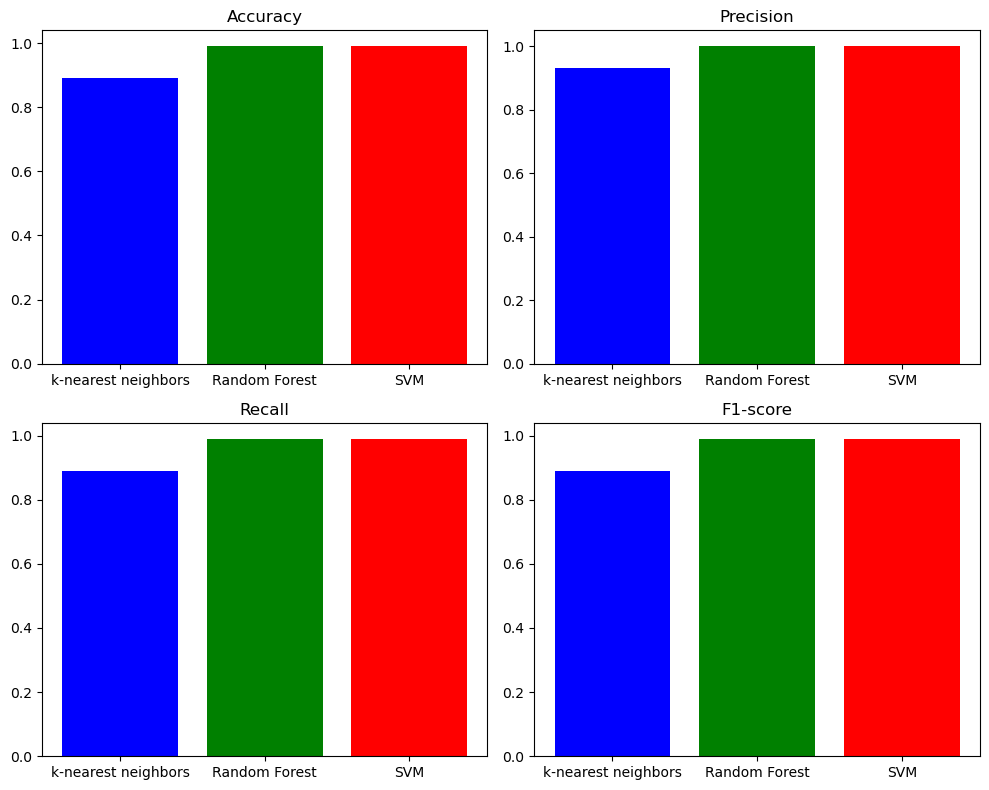

In [22]:
import matplotlib.pyplot as plt
import numpy as np

classifiers = ['k-nearest neighbors', 'Random Forest', 'SVM']

accuracy = [0.89, 0.99, 0.99]
precision = [0.93, 1, 1]
recall = [0.89, 0.99, 0.99]
f1_score = [0.89, 0.99, 0.99]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot Accuracy
axs[0, 0].bar(classifiers, accuracy, color=['blue', 'green', 'red'])
axs[0, 0].set_title('Accuracy')

# Plot Precision
axs[0, 1].bar(classifiers, precision, color=['blue', 'green', 'red'])
axs[0, 1].set_title('Precision')

# Plot Recall
axs[1, 0].bar(classifiers, recall, color=['blue', 'green', 'red'])
axs[1, 0].set_title('Recall')

# Plot F1-score
axs[1, 1].bar(classifiers, f1_score, color=['blue', 'green', 'red'])
axs[1, 1].set_title('F1-score')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
